# Autonomous Delivery Agent — Project 1 (ready-to-run)
Implements:
- Environment model (terrain costs, static & dynamic obstacles)
- BFS (for uniform-cost=1 grids)
- Uniform-Cost Search (UCS)
- A* (Manhattan heuristic)
- Simple local-search replanner (hill-climbing with random restarts)
- Experimental comparison and dynamic replanning demo

This notebook follows the project brief.

Instructions: run each code cell in order.

In [1]:

# Part 1: Imports and Utilities
import heapq
import time
import random
import copy
from collections import deque, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display

# Reproducibility
RNG = random.Random(42)
np.random.seed(42)

# Utility: 4-connected moves
MOVES = [(-1,0),(1,0),(0,-1),(0,1)]
DIR_NAMES = {(-1,0):'U',(1,0):'D',(0,-1):'L',(0,1):'R'}

# Simple helper to show grid
def show_grid(grid, path=None, start=None, goal=None, dynamic_positions=None, title="Grid"):
    # grid: 2D array of ints where -1 means obstacle
    img = np.zeros((*grid.shape, 3), dtype=float)
    maxcost = max(1, int(np.nanmax(np.where(grid>0, grid, 0))))
    for r in range(grid.shape[0]):
        for c in range(grid.shape[1]):
            if grid[r,c] < 0:
                img[r,c] = np.array([0.0,0.0,0.0])  # black obstacle
            else:
                val = grid[r,c] / maxcost
                img[r,c] = np.array([1-val, 1-val, 1])  # bluish
    if path:
        for (r,c) in path:
            img[r,c] = np.array([0.0,1.0,0.0])  # green path
    if start:
        img[start] = np.array([0.0,0.0,1.0])  # blue start
    if goal:
        img[goal] = np.array([1.0,0.0,0.0])   # red goal
    if dynamic_positions:
        for (r,c) in dynamic_positions:
            img[r,c] = np.array([1.0,1.0,0.0])  # yellow moving obstacle
    plt.figure(figsize=(6,6))
    plt.imshow(img, origin='upper')
    plt.title(title)
    plt.axis('off')
    plt.show()

# ... (rest of the notebook code from previous answer continues)


ModuleNotFoundError: No module named 'pandas'

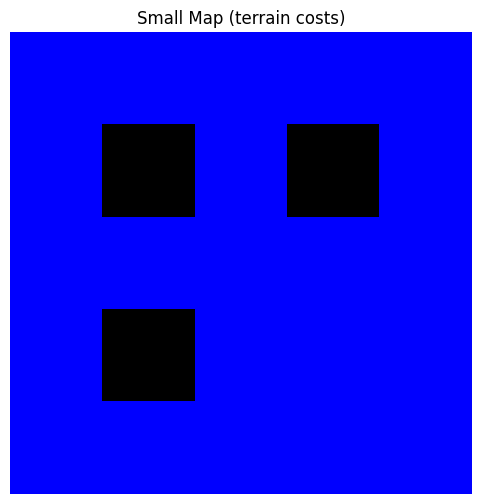

BFS nodes expanded: 22 time(s): 6.839999696239829e-05 cost: 8


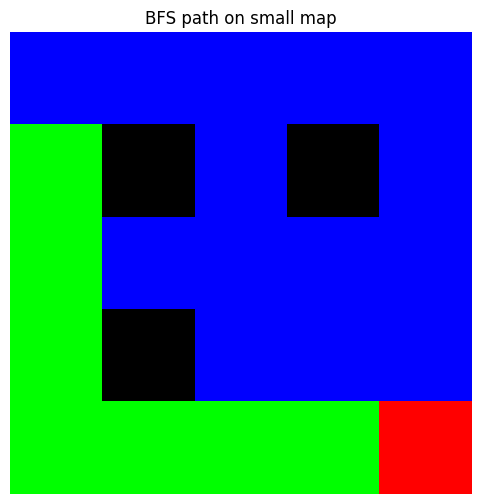

UCS nodes expanded: 22 time(s): 0.00015310000162571669 cost: 8


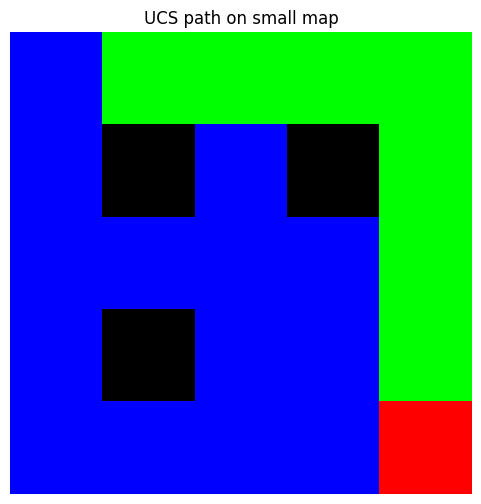

A* nodes expanded: 22 time(s): 0.00023749998945277184 cost: 8


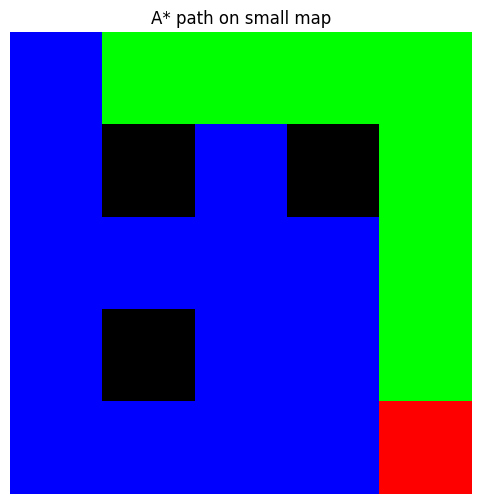

=== Small map ===


,algo,cost,nodes_expanded,time_s,path_len
0,BFS,8,22,0.000128,9
1,UCS,8,22,0.000208,9
2,A*,8,22,0.000210,9


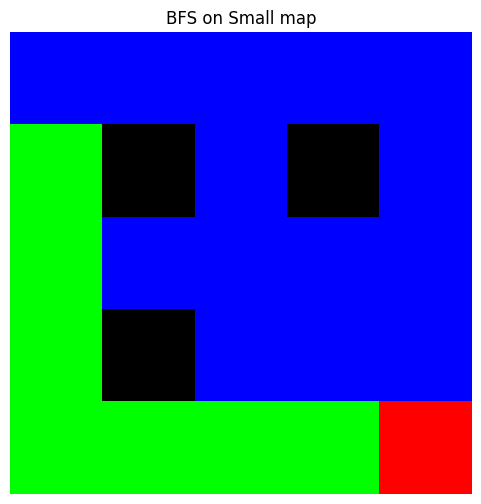

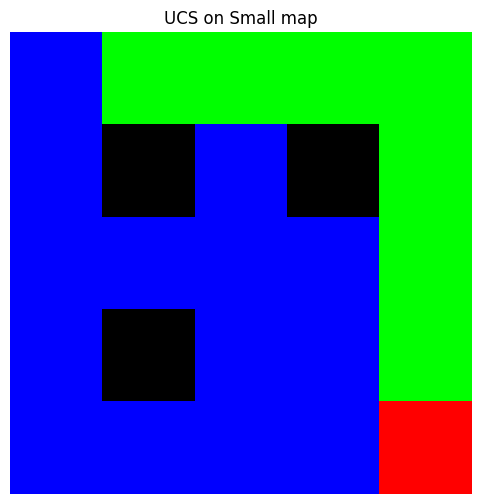

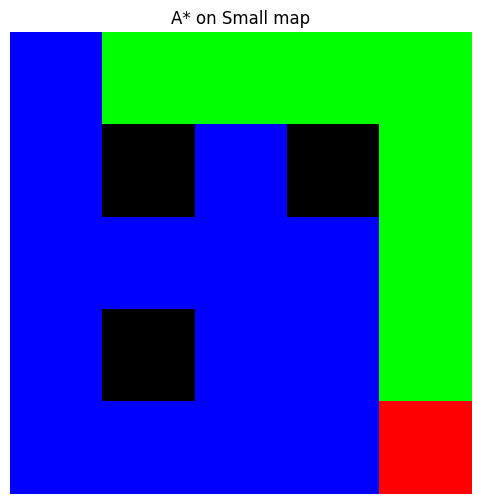

=== Medium map ===


,algo,cost,nodes_expanded,time_s,path_len
0,BFS,18,93,0.000471,19
1,UCS,18,93,0.000784,19
2,A*,18,93,0.000904,19


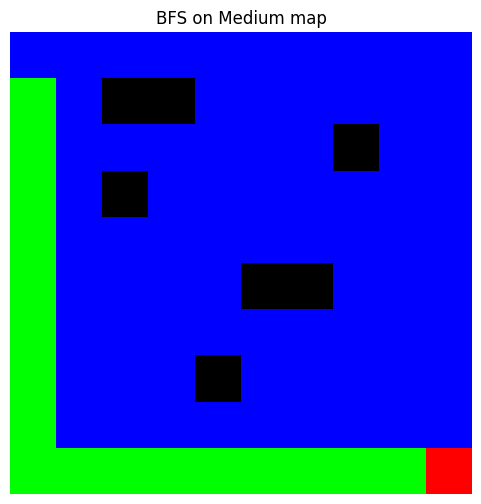

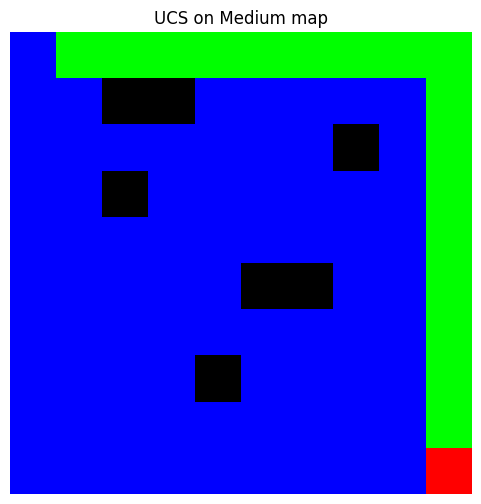

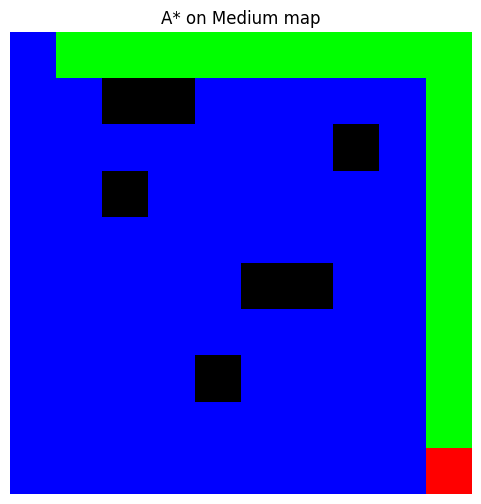

=== Large map ===


,algo,cost,nodes_expanded,time_s,path_len
0,BFS,48,130,0.000740,11
1,UCS,46,195,0.001768,15
2,A*,46,112,0.001064,15


IndexError: index 16 is out of bounds for axis 0 with size 10

In [3]:
# %% [markdown]
# # Autonomous Delivery Agent — Project 1 (ready-to-run)
# 
# Implements:
# - Environment model (terrain costs, static & dynamic obstacles)
# - BFS (for uniform-cost=1 grids)
# - Uniform-Cost Search (UCS)
# - A* (Manhattan heuristic)
# - Simple local-search replanner (hill-climbing with random restarts)
# - Experimental comparison and dynamic replanning demo
# 
# This notebook follows the project brief you provided. 
# 
# Instructions: run each code cell in order.

# %%
# Part 1: Imports and Utilities
import heapq
import time
import random
import copy
from collections import deque, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display

# Reproducibility
RNG = random.Random(42)
np.random.seed(42)

# Utility: 4-connected moves
MOVES = [(-1,0),(1,0),(0,-1),(0,1)]
DIR_NAMES = {(-1,0):'U',(1,0):'D',(0,-1):'L',(0,1):'R'}

# Simple helper to show grid
def show_grid(grid, path=None, start=None, goal=None, dynamic_positions=None, title="Grid"):
    # grid: 2D array of ints where -1 means obstacle
    img = np.zeros((*grid.shape, 3), dtype=float)
    maxcost = max(1, int(np.nanmax(np.where(grid>0, grid, 0))))
    # Color mapping: low cost -> lighter, high cost -> darker
    for r in range(grid.shape[0]):
        for c in range(grid.shape[1]):
            if grid[r,c] < 0:
                img[r,c] = np.array([0.0,0.0,0.0])  # black obstacle
            else:
                val = grid[r,c] / maxcost
                img[r,c] = np.array([1-val, 1-val, 1])  # bluish
    if path:
        for (r,c) in path:
            img[r,c] = np.array([0.0,1.0,0.0])  # green path
    if start:
        img[start] = np.array([0.0,0.0,1.0])  # blue start
    if goal:
        img[goal] = np.array([1.0,0.0,0.0])   # red goal
    if dynamic_positions:
        for (r,c) in dynamic_positions:
            img[r,c] = np.array([1.0,1.0,0.0])  # yellow moving obstacle
    plt.figure(figsize=(6,6))
    plt.imshow(img, origin='upper')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Path cost: sum of terrain costs of visited cells (including start? we include stepping costs: cost to enter each cell; start cost counts as 0)
def path_cost(grid, path):
    if not path: return float('inf')
    cost = 0
    # cost to enter each cell except start
    for i in range(1,len(path)):
        r,c = path[i]
        cost += grid[r,c]
    return cost

# Validate cell in bounds and not static obstacle
def valid_cell(grid, r, c):
    return 0 <= r < grid.shape[0] and 0 <= c < grid.shape[1] and grid[r,c] >= 0

# Reconstruct path from parent dict
def reconstruct(parent, goal):
    path = []
    node = goal
    while node is not None:
        path.append(node)
        node = parent.get(node, None)
    path.reverse()
    return path

# Metrics container
class Metrics:
    def __init__(self):
        self.nodes_expanded = 0
        self.time = 0.0
        self.path = None
        self.cost = None

# %%
# Part 1b: Map format helpers and example maps
# Grid encoding:
# -1 = static obstacle
# >=1 = terrain movement cost (integer)
# Start and goal are coordinates given separately

def map_from_text(lines):
    """
    Load grid from list of strings. Characters:
    '#' -> obstacle
    digits -> terrain cost (0 not allowed; if 0, replaced by 1)
    '.' -> cost 1
    Example:
    "....."
    "..#.."
    "11111"
    """
    rows = []
    for line in lines:
        row=[]
        for ch in line.strip():
            if ch == '#':
                row.append(-1)
            elif ch == '.':
                row.append(1)
            elif ch.isdigit():
                val = int(ch)
                row.append(val if val>0 else 1)
            else:
                # default to 1
                row.append(1)
        rows.append(row)
    return np.array(rows, dtype=int)

# Small, medium, large example maps (you can extend/save these to files)
small_map = map_from_text([
    "11111",
    "1#1#1",
    "11111",
    "1#111",
    "11111",
])
medium_map = map_from_text([
    "1111111111",
    "11##111111",
    "1111111#11",
    "11#1111111",
    "1111111111",
    "11111##111",
    "1111111111",
    "1111#11111",
    "1111111111",
    "1111111111",
])
# Large: create a 30x30 random terrain with obstacles
def make_large(n=30, obstacle_prob=0.15, max_cost=5):
    grid = np.ones((n,n), dtype=int)
    for r in range(n):
        for c in range(n):
            if RNG.random() < obstacle_prob:
                grid[r,c] = -1
            else:
                grid[r,c] = RNG.randint(1, max_cost)
    # ensure start/goal free later
    return grid

large_map = make_large(30, obstacle_prob=0.18, max_cost=9)

# Dynamic map: moving obstacle(s) with schedule
def dynamic_map_example():
    g = map_from_text([
        "11111111111",
        "1#111111111",
        "1111111#111",
        "11111111111",
        "11111111111",
        "11111#11111",
        "11111111111",
        "11111111111",
        "11111111111",
        "11111111111",
        "11111111111",
    ])
    # define moving vehicle schedule (deterministic) as dict time -> set of cells occupied
    # We'll make a vehicle that moves right along row 5 from col 2..8 over time steps
    schedule = {}
    path_positions = [(5,2+i) for i in range(7)]
    for t,pos in enumerate(path_positions):
        schedule[t] = {pos}
    # make it loop after end for demo
    return g, schedule

# Save map loader/saver for file format (simple CSV-like)
def save_map(grid, filename):
    with open(filename, 'w') as f:
        for r in range(grid.shape[0]):
            row = ''.join('#' if grid[r,c]==-1 else str(grid[r,c]) for c in range(grid.shape[1]))
            f.write(row + '\n')

def load_map(filename):
    with open(filename) as f:
        lines = f.readlines()
    return map_from_text([line.rstrip('\n') for line in lines])

# Example: show small map
show_grid(small_map, title="Small Map (terrain costs)")

# %%
# Part 2: Breadth-First Search (BFS)
# BFS is appropriate for uniform-cost = 1 grids. We'll implement BFS that returns shortest *in steps* path.
def bfs(grid, start, goal):
    m = Metrics()
    t0 = time.perf_counter()
    frontier = deque([start])
    parent = {start: None}
    visited = set([start])
    found = False
    while frontier:
        node = frontier.popleft()
        m.nodes_expanded += 1
        if node == goal:
            found = True
            break
        r,c = node
        for dr,dc in MOVES:
            nr,nc = r+dr, c+dc
            if not (0 <= nr < grid.shape[0] and 0 <= nc < grid.shape[1]): continue
            if grid[nr,nc] < 0: continue  # static obstacle
            neigh = (nr,nc)
            if neigh in visited: continue
            visited.add(neigh)
            parent[neigh] = node
            frontier.append(neigh)
    t1 = time.perf_counter()
    m.time = t1 - t0
    if found:
        m.path = reconstruct(parent, goal)
        m.cost = path_cost(grid, m.path)
    else:
        m.path = None
        m.cost = float('inf')
    return m

# Quick BFS test (uniform cost map)
start = (0,0)
goal = (4,4)
res = bfs(small_map, start, goal)
print("BFS nodes expanded:", res.nodes_expanded, "time(s):", res.time, "cost:", res.cost)
show_grid(small_map, path=res.path, start=start, goal=goal, title="BFS path on small map")

# %%
# Part 3: Uniform-Cost Search (UCS)
def ucs(grid, start, goal):
    m = Metrics()
    t0 = time.perf_counter()
    frontier = []
    heapq.heappush(frontier, (0, start))
    parent = {start: None}
    cost_so_far = {start: 0}
    visited = set()
    while frontier:
        cur_cost, node = heapq.heappop(frontier)
        if node in visited:
            continue
        visited.add(node)
        m.nodes_expanded += 1
        if node == goal:
            break
        r,c = node
        for dr,dc in MOVES:
            nr,nc = r+dr, c+dc
            if not (0 <= nr < grid.shape[0] and 0 <= nc < grid.shape[1]): continue
            if grid[nr,nc] < 0: continue
            neigh = (nr,nc)
            new_cost = cost_so_far[node] + grid[nr,nc]  # cost to enter neigh
            if neigh not in cost_so_far or new_cost < cost_so_far[neigh]:
                cost_so_far[neigh] = new_cost
                parent[neigh] = node
                heapq.heappush(frontier, (new_cost, neigh))
    t1 = time.perf_counter()
    m.time = t1 - t0
    if goal in parent:
        m.path = reconstruct(parent, goal)
        m.cost = path_cost(grid, m.path)
    else:
        m.path = None
        m.cost = float('inf')
    return m

# Quick UCS on small_map
res_ucs = ucs(small_map, start, goal)
print("UCS nodes expanded:", res_ucs.nodes_expanded, "time(s):", res_ucs.time, "cost:", res_ucs.cost)
show_grid(small_map, path=res_ucs.path, start=start, goal=goal, title="UCS path on small map")

# %%
# Part 4: A* Search (Manhattan heuristic, admissible for 4-connected grids with cost >=1)
def manhattan(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def astar(grid, start, goal, heuristic=manhattan):
    m = Metrics()
    t0 = time.perf_counter()
    frontier = []
    heapq.heappush(frontier, (heuristic(start,goal), 0, start))
    parent = {start: None}
    gscore = {start: 0}
    visited = set()
    while frontier:
        f, g, node = heapq.heappop(frontier)
        if node in visited:
            continue
        visited.add(node)
        m.nodes_expanded += 1
        if node == goal:
            break
        r,c = node
        for dr,dc in MOVES:
            nr,nc = r+dr, c+dc
            if not (0 <= nr < grid.shape[0] and 0 <= nc < grid.shape[1]): continue
            if grid[nr,nc] < 0: continue
            neigh = (nr,nc)
            tentative_g = gscore[node] + grid[nr,nc]
            if neigh not in gscore or tentative_g < gscore[neigh]:
                gscore[neigh] = tentative_g
                parent[neigh] = node
                heapq.heappush(frontier, (tentative_g + heuristic(neigh, goal), tentative_g, neigh))
    t1 = time.perf_counter()
    m.time = t1 - t0
    if goal in parent:
        m.path = reconstruct(parent, goal)
        m.cost = path_cost(grid, m.path)
    else:
        m.path = None
        m.cost = float('inf')
    return m

# Quick A* test
res_astar = astar(small_map, start, goal)
print("A* nodes expanded:", res_astar.nodes_expanded, "time(s):", res_astar.time, "cost:", res_astar.cost)
show_grid(small_map, path=res_astar.path, start=start, goal=goal, title="A* path on small map")

# %%
# Part 5: Experimental comparison across maps
def compare_algorithms(grid, start, goal, algorithms):
    results = {}
    for name, func in algorithms.items():
        try:
            m = func(grid, start, goal)
        except Exception as e:
            m = Metrics()
            m.path = None
            m.cost = float('inf')
            m.nodes_expanded = -1
            m.time = -1
        results[name] = m
    return results

# Define algorithms
algorithms = {
    'BFS': bfs,
    'UCS': ucs,
    'A*': astar
}

# Run comparisons on small and medium (example)
start_small = (0,0); goal_small = (4,4)
start_medium = (0,0); goal_medium = (9,9)
res_small = compare_algorithms(small_map, start_small, goal_small, algorithms)
res_medium = compare_algorithms(medium_map, start_medium, goal_medium, algorithms)

def print_results(title, results):
    print(f"=== {title} ===")
    rows=[]
    for k,m in results.items():
        rows.append([k, m.cost, m.nodes_expanded, m.time, len(m.path) if m.path else None])
    df = pd.DataFrame(rows, columns=['algo','cost','nodes_expanded','time_s','path_len'])
    display(df)
    for k,m in results.items():
        if m.path:
            show_grid(small_map if title.startswith("Small") else medium_map, path=m.path, start=start_small if title.startswith("Small") else start_medium, goal=goal_small if title.startswith("Small") else goal_medium, title=f"{k} on {title}")

print_results("Small map", res_small)
print_results("Medium map", res_medium)

# For large map: pick start/goal free cells
def pick_free_cell(grid):
    h,w = grid.shape
    attempts=0
    while attempts<10000:
        r = RNG.randrange(h)
        c = RNG.randrange(w)
        if grid[r,c] >= 0:
            return (r,c)
        attempts += 1
    raise RuntimeError("No free cell found")

start_large = pick_free_cell(large_map)
goal_large = pick_free_cell(large_map)
res_large = compare_algorithms(large_map, start_large, goal_large, algorithms)
print_results("Large map", res_large)

# %%
# Part 6: Dynamic Obstacles and Replanning (A* + local search replanner)
# We'll simulate time steps. At each step the agent moves one step along planned path.
# Moving obstacles have a schedule: schedule[t] -> set of cells occupied at time t.
# If the next step is occupied at the time the agent would enter it, replan.

def simulate_with_replanning(grid, start, goal, schedule, planner=astar, max_steps=500, visualize=False):
    """
    schedule: dict mapping int time -> set of (r,c) positions occupied by moving obstacles at that time.
    planner: planning function (astar or ucs). Planner must accept grid, start, goal.
    """
    log = []
    time_step = 0
    position = start
    # Ensure start/goal is not static obstacle
    if grid[start] < 0 or grid[goal] < 0:
        raise ValueError("Start or goal is on static obstacle")
    # For planning we temporarily mark dynamic positions as obstacles for the horizon of the path
    plan = planner(grid, position, goal)
    if not plan.path:
        return {'success': False, 'log': log, 'final_pos': position}
    current_path = plan.path  # list of coords starting at position
    # We'll follow path; if next cell is occupied at time+1, replan
    steps = 0
    while position != goal and steps < max_steps:
        # Compute next desired cell (if path length >=2)
        if len(current_path) <= 1:
            # no moves left but not at goal -> stuck
            break
        next_cell = current_path[1]
        occupied_next = (time_step+1 in schedule and next_cell in schedule[time_step+1])
        occupied_now = (time_step in schedule and position in schedule[time_step])
        # If our current position is occupied at current time (collision), fail
        if occupied_now:
            log.append((time_step, position, 'collision_at_position'))
            return {'success': False, 'log': log, 'final_pos': position}
        if occupied_next:
            # Replan: mark positions that will be occupied at times >= time_step+1 as temporarily blocked for planning
            temp_grid = grid.copy()
            # For the planner, we'll mark all scheduled positions from now to some horizon as obstacles.
            horizon = time_step + max(10, len(current_path)+5)
            for t in range(time_step+1, horizon+1):
                if t in schedule:
                    for (r,c) in schedule[t]:
                        # If it's within bounds, mark as obstacle in temporary grid
                        if 0 <= r < temp_grid.shape[0] and 0 <= c < temp_grid.shape[1]:
                            temp_grid[r,c] = -1
            # Replan using temporary grid
            replanner = planner
            plan2 = replanner(temp_grid, position, goal)
            log.append((time_step, position, 'replan', next_cell, True if plan2.path else False))
            if plan2.path:
                current_path = plan2.path
            else:
                # If planner fails, try local search replanner (hill-climbing with random restarts)
                hs = local_search_replanner(grid, position, goal, schedule, time_step)
                log.append((time_step, position, 'local_search_replan', hs is not None))
                if hs:
                    current_path = hs
                else:
                    # give up
                    return {'success': False, 'log': log, 'final_pos': position}
        # Move one step
        position = current_path[1]
        # trim path
        current_path = current_path[1:]
        time_step += 1
        steps += 1
        log.append((time_step, position, 'move'))
        if visualize:
            dyn = schedule.get(time_step, set())
            show_grid(grid, path=current_path, start=position, goal=goal, dynamic_positions=dyn, title=f"t={time_step}")
    success = position == goal
    return {'success': success, 'log': log, 'final_pos': position, 'time_steps': time_step}

# Local search replanner (hill-climbing with random restarts)
def local_search_replanner(grid, start, goal, schedule, current_time, max_iters=200, restarts=10):
    """
    Proof-of-concept: generate random candidate paths (via random walks biased to goal),
    then try small local changes (remove loops, replace a segment by a greedy route) to reduce path cost.
    This is not guaranteed optimal but provides a fallback when A* with blocked cells fails.
    """
    best = None
    best_cost = float('inf')
    h = manhattan
    h_goal = lambda n: h(n, goal)
    H = grid.shape[0]*grid.shape[1]
    for r in range(restarts):
        # Randomized greedy walk: sometimes choose a neighbor that reduces heuristic, sometimes random
        path = [start]
        visited=set([start])
        steps=0
        while path[-1] != goal and steps < H:
            cur = path[-1]
            neighbors=[]
            for dr,dc in MOVES:
                nr,nc = cur[0]+dr, cur[1]+dc
                if not (0 <= nr < grid.shape[0] and 0 <= nc < grid.shape[1]): continue
                if grid[nr,nc] < 0: continue
                # check dynamic occupancy at the time we'd arrive
                arrival_time = current_time + len(path)
                if arrival_time in schedule and (nr,nc) in schedule[arrival_time]:
                    continue
                neighbors.append((nr,nc))
            if not neighbors:
                break
            # with some prob pick neighbor with smallest heuristic
            if RNG.random() < 0.8:
                neighbors.sort(key=lambda x: h_goal(x))
                nxt = neighbors[0]
            else:
                nxt = RNG.choice(neighbors)
            if nxt in visited:
                # loop detected, random jump to break loop
                if len(neighbors)>1:
                    nxt = neighbors[RNG.randrange(len(neighbors))]
                else:
                    break
            path.append(nxt)
            visited.add(nxt)
            steps += 1
        # If reached goal, attempt local improvements: remove obvious loops
        if path[-1] == goal:
            # simple smoothing: if nonconsecutive points are adjacent, remove intermediate nodes
            improved = True
            while improved:
                improved=False
                i=0
                while i < len(path)-2:
                    if abs(path[i][0]-path[i+2][0]) + abs(path[i][1]-path[i+2][1]) == 1:
                        # can skip path[i+1]
                        path.pop(i+1)
                        improved=True
                    else:
                        i+=1
            cost = path_cost(grid, path)
            if cost < best_cost:
                best = path
                best_cost = cost
    return best

# Demo: dynamic example map
dyn_grid, schedule = dynamic_map_example()
start_dyn = (0,0)
goal_dyn = (10-1,10-1)  # bottom-right
show_grid(dyn_grid, start=start_dyn, goal=goal_dyn, title="Dynamic map (static)")

print("Schedule (time->positions):")
for t in sorted(schedule.keys()):
    print(t, schedule[t])

sim = simulate_with_replanning(dyn_grid, start_dyn, goal_dyn, schedule, planner=astar, visualize=False)
print("Dynamic simulation result:", sim['success'])
print("Log sample (first 20 entries):", sim['log'][:20])

# Visualize agent following and dynamic obstacle frames
def animate_simulation(grid, start, goal, schedule, planner=astar, max_frames=50, delay=0.5):
    sim = simulate_with_replanning(grid, start, goal, schedule, planner=planner, visualize=False)
    pos = start
    # reconstruct positions from log (entries with 'move')
    frames = []
    frames.append((0,pos))
    for entry in sim['log']:
        if entry[2]=='move':
            frames.append((entry[0], entry[1]))
    for t, p in frames[:max_frames]:
        clear_output(wait=True)
        dyn = schedule.get(t, set())
        title = f"t={t} pos={p}"
        show_grid(grid, start=p, goal=goal, dynamic_positions=dyn, title=title)
        time.sleep(delay)

# Uncomment below to animate in notebook (keeps inline)
# animate_simulation(dyn_grid, start_dyn, goal_dyn, schedule, planner=astar, delay=0.3)

# %%
# Part 6b: Compare replanning strategies
# We'll compare: (1) A* with immediate replanning when blocked (above), (2) A* + local search fallback (already used),
# For demonstration we'll run two simulations and compare success/time.
def run_dynamic_experiments(grid, schedule, start, goal, planners):
    rows=[]
    for name, planner in planners.items():
        t0 = time.perf_counter()
        sim = simulate_with_replanning(grid, start, goal, schedule, planner=planner, visualize=False)
        t1 = time.perf_counter()
        rows.append([name, sim.get('success',False), sim.get('time_steps', None), len(sim.get('log',[])), t1-t0, sim.get('final_pos')])
    df = pd.DataFrame(rows, columns=['strategy','success','time_steps','log_len','wall_time_s','final_pos'])
    return df

planners = {
    'A*_replan': astar,
    'UCS_replan': ucs
}
df_dyn = run_dynamic_experiments(dyn_grid, schedule, start_dyn, goal_dyn, planners)
display(df_dyn)

# %%
# Part 7: Saving results and simple plots
# Example: run trials on small/medium/large maps and store metrics
def run_trials(maps, starts_goals, algorithms):
    rows=[]
    for name, grid in maps.items():
        start,goal = starts_goals[name]
        for alg_name, alg in algorithms.items():
            t0=time.perf_counter()
            m = alg(grid, start, goal)
            t1=time.perf_counter()
            rows.append({
                'map':name,
                'algo':alg_name,
                'cost':m.cost,
                'nodes_expanded':m.nodes_expanded,
                'time_s':m.time,
                'wall_time': t1-t0,
                'path_len': len(m.path) if m.path else None
            })
    return pd.DataFrame(rows)

maps = {'small': small_map, 'medium': medium_map, 'large': large_map}
starts_goals = {'small': (start_small, goal_small), 'medium': (start_medium, goal_medium), 'large': (start_large, goal_large)}
df_trials = run_trials(maps, starts_goals, algorithms)
display(df_trials)

# Simple bar plot: nodes expanded per algorithm per map
plt.figure(figsize=(8,4))
for i, group in df_trials.groupby('map'):
    plt.subplot(1,3, ['small','medium','large'].index(i)+1)
    plt.bar(group['algo'], group['nodes_expanded'])
    plt.title(i)
    plt.ylabel('nodes expanded')
plt.tight_layout()
plt.show()


